# Music genre classification

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Misc
import os, sys
from glob import glob

In [3]:
import random

In [4]:
# Dataframes and such
import pandas as pd
import numpy as np

In [5]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Ipython stuff
import IPython
import IPython.display as ipd

In [7]:
# Audio stuff
import librosa
import librosa.display

In [8]:
from tqdm.notebook import tqdm

In [9]:
# This must point to the root folder of the GTZAN dataset (the folder containing all genres subfolders)
DATA_FOLDER = "../data/gtzan"

## Table of contents

* [Introduction and project description](#Introduction-and-project-description)
* [Dataset](#Dataset)
* [Experimental setup](#Experimental-setup)
* [Data augmentation](#Data-augmentation)
* [Modeling](#Modeling)
* [Training](#Training)
* [Results](#Results)
* [Future works](#Future-works)
* [Misc](#Misc)

## Introduction and project description

The goal of the project is pretty straightforward: train a Machine Learning model able to classify an audio clip as one of ten possible genres, using the GTZAN dataset.

I chose to focus on the first question, i.e. "Make a good model".

### Project organization

Having a little more than a weekend at my disposal, I organized the work identifying the following tasks, here listed in the rough order in which I did them:

 1. Base exploratory data analysis; 
 1. Setting up dataset transformations (creating mel spectrograms);
 1. Setting up pipeline for creating augmentations;
 1. Model training, iteration on models/hyperparameters;
 1. Writing report and documentation.
 
I estimated ~40% of the time to be dedicated to the first 3 tasks (mostly because this required me to write custom code that I didn't have available, so I wanted to keep margin for error), ~40% of the time for training models (simply because I expected long-ish training times due to the experiment setup, more on that in a later Section) and the remaining ~20% of the time for writing the report and going one final time through the code to improve its quality/readability.

Some of the code used in this assignment was already available from past experimentations with the dataset, other pieces were cannibalized from code I used a while ago to keep track of experiments using [Sacred](https://github.com/IDSIA/sacred).

### Cutting some corners

Due to time constraints, some decisions had to be made before starting to work, to try to avoid dangerous time-consuming pitfalls:

 * use known architectures: I avoided trying anything "too exotic" to avoid wasting time trying to fix bugs in something that at best could give me a **hardly defendable** (more on this in the **Dataset** Section) 0.3% increase in accuracy;
 * spend a limited amount of time exploring different architectures: my feeling is that for this specific dataset and using a CNN-based approach, unless significantly more time is spent researching an architecture that can provide the best possible representation of the input data, any _reasonable_ choice for a network would work for my purposes. Again, more on this in the next Section;
 * prioritize "small" models: given the limited amount of available data, I only considered "small" version of common architectures, mainly to speed up the iteration process;
 * manage expectations: spend some time trying to get a grasp of what kind of results (in terms of classification accuracy) I could hope to achieve, to avoid wasting time overfitting noise. More details on this in the following section.
 
These however are all choices that, in the worst case scenario, _limit_ the accuracy achieved. The way I chose to evaluate the performances, i.e. K-fold cross validation without a proper separate validation subset for hyperparameter optimization, potentially leads to _slightly_ positively biased results, albeit I considered the effect of this to be very limited, and (as long as acknowledged) acceptable in this scenario. I will address this in more detail in a later Section.

[Back to top](#Table-of-contents)

## Dataset

The dataset is the GTZAN Genre Collection dataset from

>Tzanetakis, George, and Perry Cook. "Musical genre classification of audio signals." IEEE Transactions on speech and audio processing 10.5 (2002): 293-302.

It consists of a total of 1000 audio clips in .wav format, sampled at 22050 Hz 16 bits, divided in 10 groups, one for each of the ten music genres included in this dataset: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae and rock. Each group is represented by 100 samples, and each sample is 30s long.

The dataset also includes the mel spectrograms generated for each of the audio clips included, in the form of RGBA images, to facilitate experimentation using CNNs.

### General considerations

I would like to take some time to discuss some crucial aspects of the task at hand that have to do with the nature of the data, and specifically with the way it has been annotated, what it implies, and how it affects the project.
I'm referring specifically to the fact that each one of the 1000 samples has been annotated with exactly **one** label, defining its genre, which makes the choice of a single-label classification approach the most natural.

There are however, in my opinion, some issues with this, some of which are addressed in more detail in a [report](https://arxiv.org/abs/1306.1461) referenced in the assignment's description. My main problem with the framing described above is that, unlike some other tasks such as the extremely popular digits recognition using the MNIST dataset, there is not a precise definition (or at least one which is quantifiable enough) of what characteristics a song should have to be considered of a certain genre. This is due to the nature and the evolution of music: genres evolved from one another, and there are a lot of cases where it is ultimately quite subjective whether a song is rock, blues metal or pop. This effectively translates in an objective difficulty in the assignment of a genre to a song in some cases.

Moreover, it is not uncommon for songs to have sections that, if taken out of context, could very well sound as belonging to a different genres: the classical parts in modern power metal songs (e.g. Stratovarius), or rock ballads that have a more "pop" feel (see as an example file `rock.00049.wav`).

My point is, I believe that a single-label annotation fails to capture the complexity of this type of data, and this should be taken into account both in the experiment design and in the evaluation.

Other issues reported in the paper linked above highlight other issues, such as

* high variability in audio quality in samples;
* heavy artist repetition, which leads to not-really-i.i.d. dataset;
* actual mislabeling of some samples.

tl;dr, I believe there is an upper bound to the achievable accuracy, and getting a model with extremely high accuracy is not only unlikely, but would be suspicious.

### Expectation management

When starting a project such as this one, I like to get a sense of what kind of performances I can expect (and, also important, what NOT to expect), given the data available and the nature of the task.
After a quick google search, 

Specifically, [Papers With Code](https://paperswithcode.com/sota/music-genre-classification-on-gtzan) reports an accuracy of 83.9% on this exact task. I skimmed through the actual paper used to produce that result but couldn't find an actual description of exactly _how_ that number was obtained, as in what set it was tested on. Anyway I considered that to be an overall reasonable reference for the _range_ of accuracy that I could achieve. 
Other papers report significantly higher results ([87.4%](https://www.isca-speech.org/archive_v0/Interspeech_2016/pdfs/1236.PDF), [93.65%](https://www.mdpi.com/2079-9292/10/18/2206#:~:text=The%20best%20classification%20accuracy%20on,superior%20to%20most%20current%20methods.)), but having only skimmed through abstracts I don't know how the performances were evaluated (and in general I'm a bit suspicious about the second one, given the considerations from the previous section).

tl;dr If I achieve somewhat around 80% accuracy I'll be more than happy.

### Checking the data

Due to the nature of the data (the fact that they are audio files), to get an idea of the samples available in GTZAN I simply listened to a few random audio files from different genres.

Since this was a well-known benchmark dataset, I didn't really need to check other things like labels distribution, sample duration or sampling rates.

In [12]:
# Make a list of all the wav files in the dataset and store them in a variable
audio_files = glob(f"{DATA_FOLDER}/*/*.wav")

In [13]:
random_file = random.choice(audio_files)
print(f"Showing random file {os.path.basename(random_file)}")
ipd.Audio(random_file)

Showing random file rock.00049.wav


In [14]:
# Load audio file with librosa
y, sr = librosa.load(random_file)

print(f"y is a {type(y)}, sr is a {type(sr)}")
print(f"First 10 elements of y: {y[:10]}")
print(f"Shape of Y: {y.shape}")
print(f"Sample Rate: {sr}")

y is a <class 'numpy.ndarray'>, sr is a <class 'int'>
First 10 elements of y: [0.01974487 0.0213623  0.0222168  0.02243042 0.02301025 0.02584839
 0.02642822 0.03018188 0.03201294 0.0324707 ]
Shape of Y: (661794,)
Sample Rate: 22050


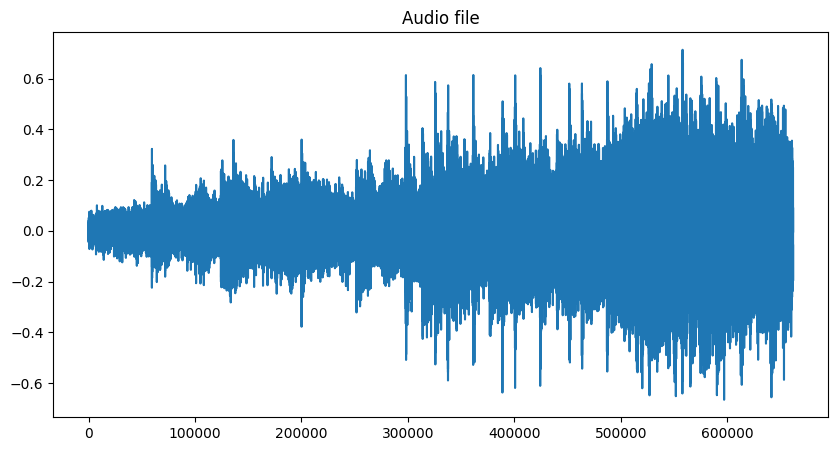

In [15]:
# Plot the actual wave
plt.figure(figsize=(16, 8))
pd.Series(y).plot(figsize=(10, 5), title="Audio file");

The only thing I noticed (I actually noticed this later during data transformation, but it fits better in this Section) is that one of the files appears to be corrupted in some way (file `jazz.00054.wav`), and thus has been removed from the dataset. I assumed removing one file out of 1000 only would not really impact significantly the results of the experiments.

### MEL Spectrograms

One common approache to analyze audio data is to generate **Mel Spectrograms** from the audio samples. Without getting too much into detail on the nature of these spectrograms, which is beyond the point of this report, Mel spectrograms provide a representation of an audio clip as a 2D array, the x axis representing **time** and the y axis representing **frequency bins in the Mel scale**.

The peculiarity of the Mel scale is that it provides a representation of frequencies such that it resembles the way that we humans perceive it (as we happen to not be great at appreciating differences in a linear scale), meaning that differences in "color" (intensity) in the Mel spectrogram better represent differences in frequency/pitch than if we were using a linear scale.

| ![If you're seeing this text, your internet died](https://www.sfu.ca/sonic-studio-webdav/handbook/Graphics/Mel.gif) |
|:--:|
| Image from [Simon Fraser University](https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html) |

For more information about Mel spectrograms, I found [this](http://gipsy-danger:8888/notebooks/notebooks/Report.ipynb#Music-genre-classification) article on Medium to give a nice explanation on the subject.

The `librosa` package provides functions to generate Mel spectrograms from an audio clip. These functions accept several parameters that change how the underlying Short-Time Fourier Transform is computed on the original signal, and the number of Mel bands generated.

For our purposes (and because I didn't really know how to do better than that), I kept the default values for these parameters (in the following cell).

In [16]:
hop_length = 512
n_fft = 2048
n_mels = 256

In [17]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
print("Shape of Mel Spectogram", S.shape)

# use that converting function as above
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

Shape of Mel Spectogram (256, 1293)


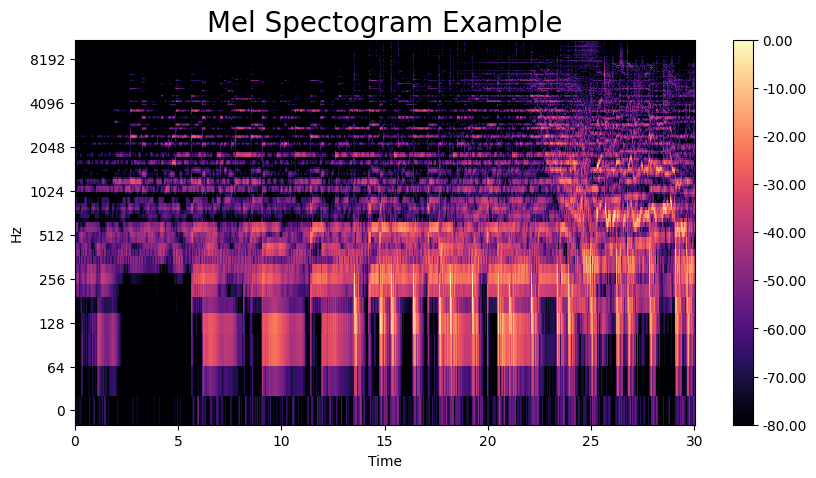

In [18]:
# plot the mel spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

One thing to note is that while the above plot of the Mel spectrogram is colored, as it uses the default color map often used for this type of spectrograms in order to make it more readable, the spectrogram itself is a 2D array of shape `(n_mels, T)`, where `T` is proportional to the duration of the original audio clip.

This will require some hacking when setting up the training pipeline, but we'll get to that in a later section.

As a final note, the GTZAN dataset I downloaded also included pre-computed spectrograms, however we're not going to use those for several reasons:

* we're planning to do data augmentation on the dataset, adding audio effects to the original signal **before** computing the spectrograms, therefore I wouldn't be able to use them anyway;
* those are RGBA images, since they have probably been exported from a plot such as the one generated above. however, as stated previously, the actual spectrograms are 2D arrays, which means that all the _information_ is contained in one channel only (as opposed to 3 or 4 for colored RGB/RGBA images). There is no reason to use the colored version, I'm guessing those are included to facilitate the use of this dataset off the shelf with traditional CNNs, that usually are designed to receive in input RGB images;
* this is personal, but it bothers me that they have a white padding.

[Back to top](#Table-of-contents)

## Experimental setup

I decided to choose the experimental setup based on how I would later assess the performance of the trained model[s] and the resources at my disposal, in terms of time and available hardware for training.

Ideally, I would have split the dataset in 10 equal splits and then ran 10 sets of experiments where one fold would have been kept as the test set for final evaluation and the remaining 9 folds used for training and hyperparameter optimization (probably using 8 folds for training and one for validation). This however would have taken quite a lot of time, especially when training a model on an augmented version of the dataset, so I ended up opting for a potentially more biased but (in my opinion) acceptable compromise: I split the dataset in only 5 folds, each containing 20% of the data, and for each fold used the remaining 80% for training. Therefore, I didn't have a proper separate test set, as I was using the one fold for each iteration as validation set to assess the performance. I (hopefully) mitigated the bias by experimenting with hyperparameters on only one subdivision (the one using `fold_0` as validation/test set) and then using the same values for all splits.

### Hyperparameter search

The only hyperparameter I ended up tweaking was the learning rate of the optimizer, as I didn't feel like the others (`gamma` parameter for learning rate scheduler or batch size) impacted significantly on the results.

Moreover, having chosen to use a pre-built architecture, I didn't really have a lot of [easily accessible] control over some of the internal parameters used, aside from the dropout, which I chose not to touch.

The decision not to play around too much with hyperparameters was also heavily influenced by the fact that already early experiments produced results with pretty good metrics around the optimistic values that I was aiming at, and at that point I didn't think it would have made sense trying to improve on those, for the reasons explained in the [Dataset](#Dataset) Section.

I used [Sacred](https://github.com/IDSIA/sacred) for tracking experiments and passing parameters to the main training script, and [Omniboard](https://github.com/vivekratnavel/omniboard) as a visualization tool. 
The MongoDB required to store experiments logs and the actual instance of omniboard were running on the same machine running the experiments, using the `docker-compose.yml` file (with one small modification to enable volume persistence, so that I wouldn't lose data in case the VM died) included in the root folder of the repository.
The training command was saved in a shell script, so that it could be executed with just one command from the terminal `./train_command.sh`.

| ![If you're seeing this text, your internet died](sacred_screenshot.png) |
|:--:|
| A screenshot of the Omniboard instance used to keep track of experiments |

[Back to top](#Table-of-contents)

## Data augmentation

Given the relatively small size of the dataset, it comes natural to consider using [data augmentation](https://medium.com/analytics-vidhya/data-augmentation-in-deep-learning-3d7a539f7a28) to artificially increase the number of available samples by creating variations of the original samples.

When the dataset consists of "natural" images, i.e. images of common objects that one might take with a camera, these variations consist of a number of geometrical and color-space transformations such as rotations, shifts, zooming in or out, slightly altering the color space and more: basically anything that would generate a new image that would easily be considered as "quite similar" to the original one.

When it comes to audio signals, and especially music samples, it makes sense to think that variations like **changing the pitch**, **stretching the time**, and **adding reverb or other effects** are good ways to augment the original dataset. Here is the procedure I followed to generate an augmented version of the GTZAN dataset.

### Data augmentation pipeline

The first thing I did was creating a `pandas.DataFrame` to list all of the available samples in the dataset and separate them by genre using the folders' name*. The output is a simple dataframe with 2 pretty self-explanatory columns: `path` and `genre`.

Then I proceeded to split the available samples in 5 _stratified_ (all categories are represented by the same number of samples) subsets. This must be done _before_ producing augmentations, as every augmented sample must belong to the same subset, to prevent data leakage that would make any experimentation meaningless.
This was done in practice by using `sklearn.model_selection.StratifiedKFold`, stratifying on the `genre` column. This adds an extra column `subset` to the dataframe, with values `fold_0`, ..., `fold_4`.

Finally, I iterate through all the rows of this dataframe and first produce the Mel spectrogram of the original sample, and then proceed to generate a number of augmentations (5) by first adding audio effects on the audio signal and then generating the Mel spectrogram from this modified signal. In both cases (the original file and the augmentations), the raw `numpy.ndarray` is saved to a `.npy` file (I'm not generating images).

A couple of things to note before going deeper in the procedure to generate augmentations:

* every generated sample is assigned to the same `subset` of the sample that it was generated from, for obvious reasons;
* I kept track of the original file an augmented sample was generated from using a new column `original`: this is technically not necessary, it was done just as an extra layer of safety so that later on I could check that there was no overlap between subsets;
* I tagged the spectrograms by including either `orig` or `aug` in the filename (saved in the `path` column) based on whether the spectrogram was from one of the **original** untouched audio samples or from one of the **augmented** ones: this would allow me later on to filter only the original samples, in case this was needed (for instance for evaluating a model only on the original samples).

#### Augmentations

Following suggestions from the assignment, I augmented the samples by performing 4 types of transormations:

* Pitch shift
* Time stretch
* Adding reverb
* Adding white noise

The guideline I followed by trial and error was to "not overdo it", as in not add so much effects that the original audio would result too different from the original/distort the audio too much (or even "change" genre, fast rock might sound dangerously close to punk or metal).

This was achieved by doing two things:

* limiting the maximum values of the internal parameters of each transformation (e.g. maximum -3 / +3 semitones for the pitch shift)
* avoiding cases where all effects are applied at their maximum "intensity" by weighting their contribution with a simple vector of weights calibrated so that they add up to 1. This is done only for the first three effects, leaving the addition of white noise independent.

```python
# Control amount of augmentation to prevent distorting the sample too much
intensities = np.random.uniform(size=(3,))
intensities /= intensities.sum()

y_aug = shift_pitch_random(y_aug, sr, intensity=intensities[0])
y_aug = time_stretch_random(y_aug, sr, intensity=intensities[1])
y_aug = reverb_random(y_aug, sr, intensity=intensities[2])
y_aug = noise_random(y_aug, sr)
```

Check out notebook [`data_augmentation.ipynb`](./data_augmentation.ipynb) to see an example of the effects of applying those transformations.

Finally, due to the time stretch transformation, the actual width of arrays might differ (as that transformation changes the length of the signal); to uniform samples, I simply slice the array so that all of them have a fixed length of 1024. This also acts as some form of "random crop" augmentation, although minimal.

The functions to perform data augmentation can be found in `src/data_augmentation.py`; the script used to generate the augmented dataset is `scripts/augmented_dataset_generation_kfold.py`.

I also considered generating the augmentations on the fly during training, which is something I sometimes do for more traditional computer vision tasks, but after a quick test it appeared clear that it would have been a bottleneck (training took significantly more time) so I decided to simply pre-generate the augmented dataset.

[\*] This was done because I had to remove the corrupted file, I honestly don't remember if the original dataset contained a csv file with that information. Point being, it was just easier to rebuild it from scratch.

[Back to top](#Table-of-contents)

## Modeling

As explained in the introduction, I decided to use pre-existing architectures from the `torchvision` package. This was done for two reasons:

1. I didn't expect to come up with a better all-purpose architecture for "image-like" data than what already exists, and more importantly
1. I could leverage the existance of pre-trained weights for those networks, as opposed to having to randomly initialize them

The second point in particular is rather important, as experiments will show that despite having been trained on a completely different type of data (Imagenet), _using pretrained weights seem to provide a much better initialization than random_. This is not necessarily intuitive, as the nature of data is considerably different, however my guess is that the filters provided by those weights still manage to capture features even from a spectrogram.

I started experimenting with [ResNet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) to perform simple tests just to see if the script worked, but used some variations of [EfficientNet](https://pytorch.org/vision/main/models/efficientnet.html) for the actual experiments, specifically **EfficientNet B1** (although I briefly experimented with variations B0 and B4). The reason I chose that is simply that I was already familiar with it and I simply consider it a "better version" of network from the ResNet family.

No major changes have been done to the architecture, with one important exception: the original version of those implementations expect 3-channel input, as they were designed to work with RGB images, which effectively are 3-D array. To have those networks work with 1-D arrays such as the spectrograms, I had to manually replace the very first layer, so that it would accept 1-channel tensors instead of 3-channels ones). The exact parameters and variable names for this operation were found by trial and error (`print` and `dir` were abused for this purpose).
In the same way, I had to manually change the very last dense layer so that it could work with the number of categories of this task (10) as opposed to the default one (1000).

It is actually possible to specify the # of classes, however **only if one does not also want to use pretrained weights**, so I just hacked my way in.

```python
net.features[0][0] = nn.Conv2d(
    1, 32, kernel_size=3, stride=2, padding=1, bias=False
)
net.classifier[1] = nn.Linear(1280, 10, bias=True)
```

The code for loading these models can be found in `src/utils.py`, and the class containing the model itself is in `src/models.py`.

All other parameters for the model were left untouched.

I used [PyTorch Lightning](https://www.pytorchlightning.ai/index.html) to wrap the actual models, since I already had some code for that lying around.

Note: the name of the lightning module class (`LitResnet`) is not exactly representative, and comes from the initial experiments with ResNet, but when I noticed this it was too late and I was a bit afraid to change working code.

[Back to top](#Table-of-contents)

## Training

### Dataset loading

The last thing left to do before the actual training can start is creating a custom Dataset class to load the `.npy` files from the disk.

The implementation is pretty straightforward, and can be found in `src/data.py`. The only potentially non-intuitive bit is the use of the `subset_mode` parameter: when set to `default`, it will return all samples for which the corresponding value in column `subset` is equal to the `subset` parameter, whereas when `subset_mode == kfold-train` it will do the opposite (return values which have a `subset` different from the one passed with the `subset` parameter). This allowed me an easy way to select samples for training when using a specific fold as validation set (the validation set is selected with mode `default`, the training set with mode `kfold-train`, passing the same fold name to both functions).

Similariy, when parameter `original_only` is set to `True`, only non-augmented samples are returned (default `False`, set to `True` for the validation set).

```python
# From scripts/train.py
dataset_train = get_dataset(
    dataset, subset=test_subset, subset_mode="kfold-train")

dataset_val = get_dataset(
    dataset, subset=test_subset, original_only=original_only_val
)
```

The only transforms that are passed at training time are the usual `ToTensor()` and a standardization one. Mean and standard deviation have been computed over folds 1, 2, 3 and 4.

### Loss function

As opposed to using the default Cross Entropy Loss function for classification, I decided to go with a slight variation and use the [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf) instead, for personal preference but also because I like the idea that it does not enforce the network to produce logits which have only one item with a significantly higher value than all others in order to be low. This intuitively (in my opinion) reflects the idea that it is ok for the network to output logits that have (significant) non-zero values for othe genres that may just very well be an acceptable classification for a genre.

| ![If you're seeing this text, your internet died](https://lh4.googleusercontent.com/_Zb8VyevBHbPdlPS1Bcph18b0GnRdY__yrSWaxEobHAOSq5izCVXdRS0Eo-26pU5Q8JE2daQAmFlwwUKnRiaf7JJrv7VJOLXbTOF-B6G8yshVWdBwhRXFBuMB5L6eH7KCTjzen-t7e39pxku5A) |
|:--:|
| Difference between CE loss and Focal Loss for different values of the $\gamma$ parameter |

The $\gamma$ parameter for the focal loss used in the experiments was $0.5$.

### Other settings

Batch size was set to $16$, learning rate to $5 \times 10^-5$. I used an exponential learning rate scheduler which multiplied the learning rate by $0.95$ at the end of each epoch.
There was a maximum number of epochs set to the super high value of $200$, but experiments were set to terminate using an **early stopping** callback monitoring the loss on the validation set at the end of each epoch, with a patience of $10$.
However, the best kept model was the one achieving the highest accuracy score on the validation set (therefore, it didn't necessarily coincide with the one having the lowest loss, although this wAs almost always the case).

### Loss curves

| ![If you're seeing this text, your internet died](loss_curves.png) |
|:--:|
| Loss curves for one of the experiments |

The reason why the training loss curve is above the validation loss curve is due to the fact that the loss is accumulated throughout the epoch, so in the beginning there are some rather high values for the training loss that skew it towards higher values.

### Experiments

Two sets of experiments were performed, one including the augmented samples and one without those. 
Each set of experiments consists of 5 separate trainings, where one of the folds is used as validation set and the remaining ones as training set. All hyperparameters are fixed for all five runs.

Moreover, experiments have been repeated using a network with randomly initialized weights, so there are a total of **4** separate sets of experiments.

Runs on non-augmented dataset took between ~12 and ~40 minutes to complete, whereas the ones on the augmented dataset took between ~40 and ~70 minutes.

[Back to top](#Table-of-contents)

## Results

Each of the four sets of experiments was evaluated with the following procedure:

1. For each fold $F_k$, the model trained using that fold as test set (i.e. using the other four folds for training) was used to predict every sample in $F_k$.
1. Accuracy $\text{acc}_k$ was computed using only samples in that fold;
1. True labels and predicted labels from $F_k$ were added to two separate lists $\mathbf{Y}$ and $\hat{\mathbf{Y}}$ respectively.
1. After all folds have been processed, I computed the mean and standard deviation of the accuracies $\text{acc}_k$. These values are reported in Table 1.
1. Finally, a confusion matrix is produced using the true and predicted labels stored in $\mathbf{Y}$ and $\hat{\mathbf{Y}}$ (Table 2).

<!---
This is the old model
..
| | No pretrain | Pretrain |
| :--- | :--- | :--- |
| <b>No augmentations</b> | 0.600 $\pm$ 0.024 | 0.820 $\pm$ 0.033 | 
| <b>Augmentations</b> | 0.694 $\pm$ 0.024 | 0.842 $\pm$ 0.042 | 
-->

| | No pretrain | Pretrain |
| :--- | :--- | :--- |
| <b>No augmentations</b> | 0.560 $\pm$ 0.035 | _0.813 $\pm$ 0.039_ | 
| <b>Augmentations</b> | 0.692 $\pm$ 0.021 | **0.830 $\pm$ 0.028** | 

<p style='text-align: center;'> Table 1 - Mean accuracies ($\pm$ standard deviations) for the four sets of experiments </p>

<!---
| | No pretrain | Pretrain |
| :--- | :---: | :---: |
| <b>No augmentations</b> | ![](./cm_noaug_nopretrain_1024.png) | ![](cm_noaug_pretrain_1024.png) | 
| <b>Augmentations</b> | ![](./cm_aug_nopretrain_1024.png) | ![](cm_aug_pretrain_1024.png) | 
-->

| | No pretrain | Pretrain |
| :--- | :---: | :---: |
| <b>No augmentations</b> | <img src="cm_noaug_nopretrain_1024.png" /> | <img src="cm_noaug_pretrain_1024.png" /> | 
| <b>Augmentations</b> | ![](./cm_aug_nopretrain_1024.png) | ![](cm_aug_pretrain_1024.png) | 

<p style='text-align: center;'> Table 2 - Mean accuracies ($\pm$ standard deviation) for the four sets of experiments </p>

Without too much surprise, the best performing approach is the one using both augmentations and pretrained weights (bottom right), although it scores only slightly better (and the difference might not even be stastically significant) than the one using no augmentations and pretrained weights (top right).
Both of those approaches however significantly outperform their counterparts on the left column, i.e. the approaches that trained the model from scratch, without using pretrained weights.

It is worth at least acknowledging that this comparison is not necessarily 100% fair, as the same set of hyperparameters were used for all four sets, and therefore do not necessarily represent the best possible results of each approach; in order to have a more fair comparison, a more sophisticated experimental design which included a proper validation set to use for hyperparameter optimization (as mentioned earlier in the report) should be adopted.

### Error analysis

Looking at the confusion matrix from the set of experiments that produced the best results it is possible to observe that the models was better at predicting some genres and worse at predicting others, in a way that (in my opinion) reflects the nature of the data:

* **Classical** audio clips was the easiest to predict; this was expected, as it is a rather different genre from all others.
* **Metal** and **Jazz** also seem to perform quite well, and this might be due to the fact that have an overall recognizable sound, although being significantly more modern than classical music, they are sometimes classified as other genres.
* **Rock** audio clips, on the other hand, have the worst performance and they're often classified as country, metal or pop; again, this is not particularly surprising given the considerations on genres made earlier. It is also interesting noting that all other categories except classical and jazz have some of their samples classified as rock.
* **Pop** also does not perform super well (relatively speaking), and is sometimes classified as country, rock and even hip-hop; same considerations done on rock apply here as well, it's a vast genre and can be expressed in many different ways.

| |
| :---: |
| ![](cm_aug_pretrain_1024.png) |
| Confusion matrix for the best performing set of experiments (using augmentations and pretrained weights) |

Just because it was super fast, I also wrote a small Dockerfile for an image with a simple endpoint using [FastAPI](https://fastapi.tiangolo.com/) that performs predictions on a single audio file at a time, using **one** of the available checkpoints (which must be specified when the image is built).

Clearly this is not expected to have any value from the point of view of the prediction, as it uses only one of the checkpoints, it's just to play around with it.

Instructions on how to build, serve and use the API are included in the `README.md` file.

[Back to top](#Table-of-contents)

## Deployment

[Back to top](#Table-of-contents)

## Future works

In a hypotetical scenario where I would continue working on this task, here are the improvements I would consider.

* Have a more proper experimental setup like the one described earlier: for each fold, use the test set exclusively for testing, performing any kind of hyperparameter optimization using exclusively the training set (thus dividing it further in training/validation set).
* Do a proper research on what architecture seem to work best on actual spectrograms (as opposed to taking a generic CNN).
* Consider an approach that takes into account the sequential nature of the signal, possibly using some sort of LSTM (this is me just brainstorming, not really sure how that would work exactly).
* Experiment with more transformation in the audio space (additional effects, different types of noise, etc.).
* Do a proper hyperparameter search, and consider alternative learning rate schedulers.

The most important thing however would probably be analyze further the dataset to assess the severity of its flow, to avoid wasting time in a problem that might be ill-posed to begin with.

[Back to top](#Table-of-contents)

## Misc


* Python version: `3.10.10`
* Python packages were managed using `poetry`; instructions on how to install `poetry` and setup the virtual environment required to train and evaluate the model are included in the `README.md` file in the root of this repository
* Code was linted using **black**.
* Experiments were performed on a VM hosted on GCP mounting one Nvidia T4
* Driver info from `nvidia-smi`: `NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0`

[Back to top](#Table-of-contents)